In [1]:
from matplotlib import pyplot as plt

from confutils import get_initial_structure, get_dihedral_info, set_dihedrals_and_relax, relax_structure
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import time
import tensorflow as tf
import random

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from collections import deque

This is my first go at the group project. It currently can one 1 round and actually does minimize energy. That's progress. I'm getting an error with the modified tensor board which I didnt make and I don't know what to do with it. That's my next prject. If you want to have a go at fixing it, be my guest.

# Things you can do:
    
   1) The convergence criterion doesn't work because it osicillates around a plateau and doesnt ever get to a point where it continually gets worse at the end. Please implement a new finishing criterion that takes the average over the last 100 steps. If the average over 100 steps stops changing significantly, we will define that plateau.
   -This requires that you look at the percentage that it changes by at each step and select a percentage that defines a plateau.
   
   
   2) You can pull your own version of this and try to define the intial functions and classes in .py files that can be imported. This got messy with the dependencies so I just shoved them all in here.
   3) Find a way to evaluate the accuracy of the fit and prediction of the q values. Add this to the DQNagent. Ask it to plot error as it goes so we can see how it's performing. 
   
   
   4) plot all energy values as each game progresses. Do you see any local minima
   
   
   5) the MAIN thing we need is to get it to run for multiple rounds.

In [2]:
def evaluate_energy(angles):
    """Compute the energy of a cysteine molecule given dihedral angles
    
    Args:
        angles: List of dihedral angles
    Returns:
        energy of the structure
    """
    return set_dihedrals_and_relax(
        cysteine,
        zip(angles, dihedrals)
    )

In [3]:
WIN_REWARD=100
MOVE_REWARD=1
epsilon=.9
eps_decay=.9998
start_q_table= None
learning=.1
discount=.95
def get_all(smiles,backbone_atoms,backbone_bonds):
    atoms, bonds = get_initial_structure(smiles)
   
    start_energy = relax_structure(atoms)
    diheds=[]
    for i in backbone_bonds:
        di=get_dihedral_info(bonds,i, backbone_atoms=backbone_atoms)
        diheds.append(di)
        
    init_state=np.random.uniform(-180,180,len(diheds))
    
    energy=set_dihedrals_and_relax(
        atoms,
        zip(init_state, diheds)
    )
    
    return atoms, diheds,energy,init_state

      
    
get_all('C([C@@H](C(=O)O)N)S',[0, 1, 3, 5, 6, 7],[[1,3],[1, 0],[1, 6],[3, 5],[0, 7]])  

(Atoms(symbols='C2HCO2NSH6', pbc=False, constraint=FixInternals(_copy_init=[FixDihedral(111.01948280324353, [0, 1, 3, 5]), FixDihedral(48.18428332148011, [3, 1, 0, 7]), FixDihedral(-92.67739011337167, [0, 1, 6, 11]), FixDihedral(149.34099867428546, [1, 3, 5, 10]), FixDihedral(-27.606378634514414, [1, 0, 7, 13])], epsilon=1e-07), calculator=Calculator(...)),
 [DihedralInfo(chain=[0, 1, 3, 5], group={10, 3, 4, 5}),
  DihedralInfo(chain=[3, 1, 0, 7], group={0, 7, 8, 9, 13}),
  DihedralInfo(chain=[0, 1, 6, 11], group={11, 12, 6}),
  DihedralInfo(chain=[1, 3, 5, 10], group={10, 5}),
  DihedralInfo(chain=[1, 0, 7, 13], group={13, 7})],
 -19641.613722554852,
 array([111.0194828 ,  48.18428332, -92.67739011, 149.34099867,
        -27.60637863]))

In [17]:
class Molecule:
    def __init__(self,smiles,backbone_atoms,backbone_bonds):
        self.bbonds=backbone_bonds
        self.n_choices=len(self.bbonds)
        self.atoms, self.dihedrals, self.energy, self.angles=get_all(smiles,backbone_atoms,backbone_bonds)
    def get_energy(self):
        self.energy=set_dihedrals_and_relax(self.atoms,zip(self.angles, self.dihedrals))
        return self.energy
    choices=[]
    def action(self,choice):
        if choice %2 ==0:
            self.angles[int(choice/2)]+=1.0
            if abs(self.angles[int(choice/2)])>180:
                self.angles[int(choice/2)]=self.angles[int(choice/2)]%180
            
        else:
            self.angles[int(np.round(choice/2))]-=1.0
            if abs(self.angles[int(choice/2)])>180:
                self.angles[int(choice/2)]=self.angles[int(choice/2)]%180
            


            
class MolEnv:
    mol = Molecule('C([C@@H](C(=O)O)N)S',[0, 1, 3, 5, 6, 7],[[1,3],[1, 0],[1, 6],[3, 5],[0, 7]])
    SIZE = 360 #We dont have a finite size in this way
    RETURN_IMAGES = False
    ENERGY_REWARD=1
    MIN_REWARD = 25
    OBSERVATION_SPACE_VALUES = [360 for i in range(mol.n_choices)]
    OBSERVATION_SPACE_VALUES.append(mol.n_choices)# 4 #WHAT IS GOING ON HERE
    ACTION_SPACE_SIZE = mol.n_choices*2
    OBSERVATION_SPACE_VALUES=tuple(OBSERVATION_SPACE_VALUES)
    reward=0
    def __init__(self):
        self.energy_list=[]
        self.strike=0
        self.reward=0
    def reset(self):
        self.mol = Molecule('C([C@@H](C(=O)O)N)S',[0, 1, 3, 5, 6, 7],[[1,3],[1, 0],[1, 6],[3, 5],[0, 7]])
        self.ener=self.mol.get_energy()
        self.strikes=0
        self.energy_list=[]
        self.energy_list.append(self.ener)
        OBSERVATION_SPACE_VALUES = [360 for i in range(self.mol.n_choices)]
        OBSERVATION_SPACE_VALUES.append(self.mol.n_choices)# 4 #WHAT IS GOING ON HERE
        
        OBSERVATION_SPACE_VALUES=tuple(OBSERVATION_SPACE_VALUES)
        self.episode_step = 0

        if self.RETURN_IMAGES:
            observation = np.array(self.get_image())
        else:
            observation = self.mol.angles
        return observation

    def step(self, action):
        self.reward=0
        self.episode_step += 1
        
        self.mol.action(action)
        new_ener=self.mol.get_energy()
        #print(new_ener,"NEW EN")
        self.energy_list.append(new_ener)
    

        
        new_observation = self.mol.angles

        if abs(self.energy_list[self.episode_step])>abs(self.energy_list[self.episode_step-1]):
            self.strike+=1
        else:
            self.strike=0
            
        if abs(self.energy_list[self.episode_step])<abs(self.energy_list[self.episode_step-1]):
            self.reward=self.ENERGY_REWARD
            
        #plt.plot(np.arange(0,len(self.energy_list)),self.energy_list)

        done = False
        if self.strike>=2:
            self.reward+=100
            plt.plot(np.arange(0,len(self.energy_list)),self.energy_list)
            done = True

        return new_observation, self.reward, done

    #def render(self):
        #img = self.get_image()
        #img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
        #cv2.imshow("image", np.array(img))  # show it!
        #cv2.waitKey(1)

    # FOR CNN #
    #def get_image(self):
        #env = np.zeros((self.SIZE, self.SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        #env[self.food.x][self.food.y] = self.d[self.FOOD_N]  # sets the food location tile to green color
        #env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]  # sets the enemy location to red
        #env[self.player.x][self.player.y] = self.d[self.PLAYER_N]  # sets the player tile to blue
        #img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        #return img



In [9]:
REPLAY_MEMORY_SIZE = 5000
MIN_REPLAY_MEMORY_SIZE = 1000
MODEL_NAME = "256x2"
DISCOUNT=0.99
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MIN_EPSILON=.5

class DQNAgent:
    
    def __init__(self,env):

        # main model  # gets trained every step
        self.model = self.create_model()

        # Target model this is what we .predict against every step
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.target_update_counter = 0

    def create_model(self):
        
        model = Sequential()
        #model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))
        #model.add(keras.Input(shape=(REPLAY_MEMORY_SIZE,a1.n_choices)))
        model.add(keras.Input(shape=(a1.n_choices)))
        model.add(Dense(a1.n_choices))

        #model.add(Flatten())
        
        model.add(Dense(a1.n_choices,activation='linear'))

        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def get_qs(self, state, step):
        #print(*state.shape)
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/180)[0]
    def train(self, terminal_state,step):
        if len(self.replay_memory)<MIN_REPLAY_MEMORY_SIZE:
            return
    # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/180
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/180
        future_qs_list = self.target_model.predict(new_current_states)
        
        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/180, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)

        # Update target network counter every episode
                # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

In [6]:

a1=Molecule('C([C@@H](C(=O)O)N)S',[0, 1, 3, 5, 6, 7],[[1,3],[1, 0],[1, 6],[3, 5],[0, 7]])
print(a1.angles)
a1.action(2)
print(a1.angles)

[  24.18323376   54.72452303   81.79197813  138.00571811 -121.16517668]
[  24.18323376   55.72452303   81.79197813  138.00571811 -121.16517668]


# This is the part that actually runs the code

In [19]:
env=MolEnv()
EPISODES = 5
agent = DQNAgent(env)
epsilon=.9
eps_decay=.9998
AGGREGATE_STATS_EVERY=10

100%|##############################################################################| 5/5 [02:40<00:00, 32.07s/episodes]


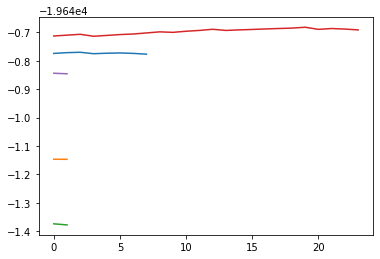

In [20]:
ep_rewards=[]
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):


    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state,step))
        else:
            # Get random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done = env.step(action)
        

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        #if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            #env.render()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        
        # Save model, but only when min reward is greater or equal a set value
        #if min_reward >= MIN_REWARD:
            #agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= eps_decay
        epsilon = max(MIN_EPSILON, epsilon)

In [ ]:
fig, ax = plt.subplots()

ax.plot(self.energy_list)